# T4.1 Clustering: algoritmo K-medias

# Índice

1. Clustering particional
2. Criterio suma de errores cuadráticos (SEC)
3. Algoritmo $K$-medias de Duda y Hart
4. Algoritmo $K$-medias convencional
5. Algoritmo $K$-medias de Lloyd

# 1. Clustering particional

**Clustering particional:** $\;$ dado un conjunto de $N$ datos $\mathcal{D}$ y un número de clusters $K,\,$ el clustering particional consiste en optimizar alguna función criterio $J(\Pi)$ para evaluar la calidad de cualquier partición $\Pi$ de los datos en $K$ clústeres:
$$\Pi^* = \operatorname*{argopt}_{\Pi} J(\Pi)$$

**Intratabilidad:** $\;$ el clustering particional es en general un problema intratable puesto que el número de particiones a explorar crece exponencialmente con $N$ y $K$. Se puede observar en [esta gráfica](./dat/stirling.pdf), que muestra el número de particiones diferentes (eje vertical) que se pueden obtener en función de $K$ (eje horizontal) para varios $N$ (curvas).

**Aproximación usual:** $\;$ hacemos uso de algoritmos aproximados para optimizar un criterio particular, como por ejemplo la suma de errores cuadráticos.

# 2. Criterio suma de errores cuadráticos (SEC)

**Suma de errores cuadráticos (SEC):** $\;$ de una partición $\Pi=\{X_1,\dotsc,X_K\}$
$$J(\Pi) = \sum_{k=1}^K J_k%
\quad\text{con}\quad%
J_k = \sum_{\boldsymbol{x}\in X_k} \lVert{\boldsymbol{x}-\boldsymbol{m}_k}\rVert_2^2
\quad\text{y}\quad%
\boldsymbol{m}_k = \frac{1}{\lvert X_k\rvert}\sum_{\boldsymbol{x}\in X_k} \boldsymbol{x}$$

**Interpretación:**
* Cada clúster $k$ se representa por su **centroide** o **media** $\,\boldsymbol{m}_k$.
* Si $\boldsymbol{x}$ pertenece al clúster $k$, $\boldsymbol{x}-\boldsymbol{m}_k$ es el **vector error** obtenido al representar $\boldsymbol{x}$ con $\boldsymbol{m}_k$.
* El error asociado a $\boldsymbol{x}$ se mide con la norma Euclidiana de su vector error, $\lVert{\boldsymbol{x}-\boldsymbol{m}_k}\rVert_2$.
* Denominamos **distorsión** del clúster $k$, $\,J_k,\,$ a la suma de errores al cuadrado de sus datos.
* El criterio SEC es la suma de las distorsiones de todos los clusters y, obviamente, es un criterio a minimizar.
* Idealmente, esperamos clusters hiper-esféricos compactos y de tamaño parecido, sobre $K$ medias bien separadas.
* Si la partición natural de los datos es distinta a la esperada, es probable que la minimización de la SEC no la encuentre.

**Ejemplo:** $\;$ cálculo de la SEC para $\Pi=\{X_1=\{(1, 7)^t, (4, 2)^t, (4,6)^t\}, X_2=\{(8, 2)^t, (8, 6)^t\}\}$

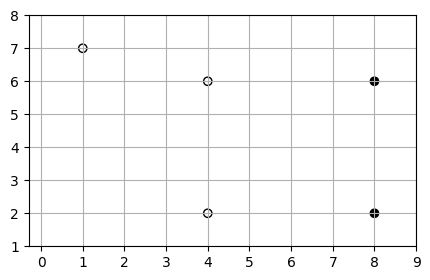

In [8]:
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(5, 3))
plt.xlim([-.3, 8.3])
plt.ylim([1.7, 7.3])
plt.xticks(np.arange(0, 10))
plt.yticks(np.arange(1, 9))
plt.grid()
X = np.array([[1,7], [4,2], [4,6], [8,2], [8,6]])
y = np.array([1, 1, 1, 2, 2])
plt.scatter(*X.T, c=y, cmap=plt.cm.binary, edgecolors='black');

$$\begin{align*}
\boldsymbol{m}_1&=(3,5)^t&&J_1=8+10+2=20\\
\boldsymbol{m}_2&=(8,4)^t&&J_2=4+4=8
\end{align*}$$
$$J=J_1+J_2=28$$

**Implementación de la solución:**

In [1]:
import numpy as np
np.set_printoptions(precision=2)

""" 
    Calcula la distorsión (SEQ) de la partición y del conjunto de datos X.

    Parámetros:
     - X: matriz de NxD con los datos.
     - y: vector de N elementos con las etiquetas (de clúster) asignadas a cada muestra.

    Devuelve una tupla de tres elementos:
     - J: SEQ de la partición.
     - m: Matriz de KxD con los centroides de cada cluster (por filas).
     - S: Vector de K elementos con el número de muestras asociadas a cada cluster.
"""
def SEQ(X, y): # labels from 0 to K-1 for simplicity
    N, D = X.shape                  # Número de muestras y dimensionalidad
    K = np.max(y)+1                 # Número de clusters
    J = 0.0                         # Distorsión de la partición
    m = np.zeros((K, D))            # matriz de centroides, por filas
    S = np.zeros(K).astype(int)     # 
    for k in range(K):              # para cada cluster k
        Xk = np.squeeze(X[np.where(y==k),:])  # Matriz de muestras asignadas al cluster k
        S[k] = Xk.shape[0]                    # Número de muestras asociadas al cluster k
        m[k] = Xk.mean(axis=0)                # Cálculo del centroide del cluster k
        J += np.square(Xk - m[k]).sum()       # Cálculamos y acumulamos la distorsión del cluster k
    return J, m, S                  

# Datos del problema para calcular la SEQ a modo de ejemplo
X = np.array([[1, 7], [4, 2], [4, 6], [8, 2], [8, 6]])  # Datos
y = np.array([0, 0, 0, 1, 1])                           # Partición
J, m, S = SEQ(X, y)                                     # Calculamos SEQ de la partición
print(f'J = {J:.2f}; m = {m.tolist()}; S = {S}')

J = 28.00; m = [[3.0, 5.0], [8.0, 4.0]]; S = [3 2]


# 3. Algoritmo $K$-medias de Duda y Hart

**Incremento de SEC al transferir una muestra de clúster:** $\;$ si se transfiere una muestra $\boldsymbol{x}$ de un clúster origen $i$ a un clúster destino $j$, el incremento de SEC es:
$$\Delta J = \frac{\lvert X_j\rvert}{\lvert X_j\rvert + 1}\lVert\boldsymbol{x}-\boldsymbol{m}_j\rVert_2^2-\frac{\lvert X_i\rvert}{\lvert X_i\rvert - 1}\lVert\boldsymbol{x}-\boldsymbol{m}_i\rVert_2^2$$

siendo $\lvert X_i\rvert$ e $\lvert X_j\rvert$ el número de muestras asociadas a los clústeres $i$ y $j$, respectivamente.

**Condición DH:** $\;$ conviene transferir si $\Delta J<0,$ es decir, si se incrementa menos $J$ en $X_j$ de lo que se decrementa en $X_i$:
$$\frac{\lvert X_j\rvert}{\lvert X_j\rvert + 1}\lVert\boldsymbol{x}-\boldsymbol{m}_j\rVert_2^2<\frac{\lvert X_i\rvert}{\lvert X_i\rvert - 1}\lVert\boldsymbol{x}-\boldsymbol{m}_i\rVert_2^2$$

**Optimalidad:** $\;$ garantiza la obtención de un mínimo **local** de la SEQ. 

**Algoritmo $K$-medias de Duda y Hart:** $\;$ para cada dato, busca la transferencia de menor $\Delta J$ y la aplica si cumple la condición DH.
> **Entrada:** $\;$ una partición inicial, $\,\Pi=\{X_1,\dotsc,X_K\}$ <br>
> **Salida:** $\;$ una partición optimizada, $\,\Pi^*=\{X_1,\dotsc,X_K\}$ <br>
> Calcular medias y $J$ <br>
> `repetir`
>> `para todo` $\;$ dato $\,\boldsymbol{x}$ <br>
>>> Sea $i$ el clúster en el que se encuentra $\boldsymbol{x}$ <br>
>>> Encontrar un $j\neq i$ que minimice $\,\triangle J\,$ al transferir $\,\boldsymbol{x}\,$ de $i$ a $j$ <br>
>>> `si` $\,\triangle J<0:\;$ transferir $\boldsymbol{x}$ de $i$ a $j$ y actualizar medias y $J$ <br>
>
> `hasta que` $\;$ no se encuentre ninguna transferencia provechosa

**Implementación:** $\;$ función para problemas sencillos.

In [2]:
import numpy as np
np.set_printoptions(precision=2, linewidth=np.inf)

def kmeansDH(X, y, max_iter=10, verbose=0):
    N = X.shape[0]
    J, m, S = SEQ(X, y)
    if verbose > 0: print(f'Init: J = {J:.2f}; m = {np.round(m, decimals=1).tolist()}; z = {S}')
    z = y.copy()
    notransfer = 0
    for iter in range(max_iter):
        if verbose > 0: print(f"Iter. {iter}:")
        for n in range(N):
            x = X[n, :]
            i = z[n]
            if S[i] == 1: continue
            D = np.square(x - m).sum(axis=1)
            Di = S[i] / (S[i] - 1.0) * D[i]
            D = S / (S + 1.0) * D
            D[i] = np.inf
            j = np.argmin(D)
            Dj = D[j]
            DJ = Dj - Di
            if verbose > 0: print(f'  x{n+1}={x}  Di={Di:5.2f}  Dj={Dj:5.2f}  D={DJ:5.2f} ', end=" ")
            if DJ < 0.0:
                z[n] = j
                S[i] -= 1
                S[j] += 1
                J += DJ
                notransfer = 1
                m[i] = m[i] - (x - m[i]) / S[i]
                m[j] = m[j] + (x - m[j]) / S[j]
                if verbose > 0: print(f'=>    transfer: J = {J:.2f}; m = {np.round(m, decimals=1).tolist()}; z = {z}')
            else: 
                if verbose > 0: print("=> no transfer"); notransfer += 1
            if notransfer == N: 
                break
        if notransfer == N: 
            if verbose > 0: print("  No more profitable transfers. Stop.")
            break
    return J, m, z

**Ejemplo (cont.):** $\quad X_1=\{\boldsymbol{x}_1=(1, 7)^t, \boldsymbol{x}_2=(4, 2)^t, \boldsymbol{x}_3=(4,6)^t\}\quad X_2=\{\boldsymbol{x}_4=(8, 2)^t, \boldsymbol{x}_5=(8, 6)^t\}$

*Nota: la siguiente tabla no se renderiza correctamente en Github (motivos desconocidos). Visualizar en Google Colab, o localmente en Jupyter Notebook, VSCode, o Antigravity.*

<center>

|$\boldsymbol{x}$|$i$|$j$|$\frac{\lvert X_i\rvert}{\lvert X_i\rvert - 1}\lVert\boldsymbol{x}-\boldsymbol{m}_i\rVert_2^2$|$\frac{\lvert X_j\rvert}{\lvert X_j\rvert + 1}\lVert\boldsymbol{x}-\boldsymbol{m}_j\rVert_2^2$|$\triangle J$|$X_1$|$X_2$|$\boldsymbol{m}_1$|$\boldsymbol{m}_2$|$J$|
|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
|||||||$\{\boldsymbol{x}_1,\boldsymbol{x}_2,\boldsymbol{x}_3\}$|$\{\boldsymbol{x}_4,\boldsymbol{x}_5\}$|$(3,5)^t$|$(8,4)^t$|$28$|
|$\boldsymbol{x}_1$|$1$|$2$|$\frac{3}{2}\cdot 8=12$|$\frac{2}{3}\cdot 58=38.67$|$26.67$||||
|$\boldsymbol{x}_2$|$1$|$2$|$\frac{3}{2}\cdot 10=15$|$\frac{2}{3}\cdot 20=13.33$|$-1.67$|$\{\boldsymbol{x}_1,\boldsymbol{x}_3\}$|$\{\boldsymbol{x}_2,\boldsymbol{x}_4,\boldsymbol{x}_5\}$|$\left(\frac{5}{2},\frac{13}{2}\right)^t$|$\left(\frac{20}{3},\frac{10}{3}\right)^t$|$26.33$|
|$\boldsymbol{x}_3$|$1$|$2$|$\frac{2}{1}\cdot\frac{10}{4}=5$|$\frac{3}{4}\cdot\frac{128}{9}=10.67$|$5.67$|
|$\boldsymbol{x}_4$|$2$|$1$|$\frac{3}{2}\cdot\frac{32}{9}=5.33$|$\frac{2}{3}\cdot\frac{101}{2}=33.67$|$28.33$|
|$\boldsymbol{x}_5$|$2$|$1$|$\frac{3}{2}\cdot\frac{80}{9}=13.33$|$\frac{2}{3}\cdot\frac{61}{2}=20.33$|$7$|
|$\boldsymbol{x}_1$|$1$|$2$|$\frac{2}{1}\cdot\frac{5}{2}=5$|$\frac{3}{4}\cdot\frac{410}{9}=34.17$|$29.17$|

</center>

In [3]:
X = np.array([[1, 7], [4, 2], [4, 6], [8, 2], [8, 6]])
y = np.array([0, 0, 0, 1, 1])
J, m, z = kmeansDH(X, y, max_iter=3, verbose=1)
print(f'\nJ = {J:.2f}; m = {np.round(m, decimals=1).tolist()}; z = {z}')

Init: J = 28.00; m = [[3.0, 5.0], [8.0, 4.0]]; z = [3 2]
Iter. 0:
  x1=[1 7]  Di=12.00  Dj=38.67  D=26.67  => no transfer
  x2=[4 2]  Di=15.00  Dj=13.33  D=-1.67  =>    transfer: J = 26.33; m = [[2.5, 6.5], [6.7, 3.3]]; z = [0 1 0 1 1]
  x3=[4 6]  Di= 5.00  Dj=10.67  D= 5.67  => no transfer
  x4=[8 2]  Di= 5.33  Dj=33.67  D=28.33  => no transfer
  x5=[8 6]  Di=13.33  Dj=20.33  D= 7.00  => no transfer
Iter. 1:
  x1=[1 7]  Di= 5.00  Dj=34.17  D=29.17  => no transfer
  No more profitable transfers. Stop.

J = 26.33; m = [[2.5, 6.5], [6.7, 3.3]]; z = [0 1 0 1 1]


# 4. Algoritmo $K$-medias convencional

**Condición convencional:** $\;$ conviene transferir $\boldsymbol{x}$ del clúster $i$ al $j$ si:
$$\lVert\boldsymbol{x}-\boldsymbol{m}_j\rVert_2^2<\lVert\boldsymbol{x}-\boldsymbol{m}_i\rVert_2^2$$

**Relación con la condición DH:** $\;$ la convencional es suficiente (pero no necesaria; ver ejemplo)
$$\frac{\lvert X_j\rvert}{\lvert X_j\rvert + 1}\lVert\boldsymbol{x}-\boldsymbol{m}_j\rVert_2^2<\lVert\boldsymbol{x}-\boldsymbol{m}_j\rVert_2^2\overset{?}{<}\lVert\boldsymbol{x}-\boldsymbol{m}_i\rVert_2^2<\frac{\lvert X_i\rvert}{\lvert X_i\rvert - 1}\lVert\boldsymbol{x}-\boldsymbol{m}_i\rVert_2^2$$

(Razonamiento) Si se cumple la condición convencional, la de D&H también; pero no necesariamente al revés. 

**Optimalidad:** $\;$ **no** garantiza la obtención de un mínimo **local** de la SEQ. 

**Algoritmo $K$-medias convencional:**
> **Entrada:** $\;$ una partición inicial, $\,\Pi=\{X_1,\dotsc,X_K\}$ <br>
> **Salida:** $\;$ una partición optimizada, $\,\Pi^*=\{X_1,\dotsc,X_K\}$ <br>
> `repetir`
>> Calcular las medias de los clusters <br>
>> Reclasificar los datos según las medias más próximas<br>
>
> `hasta que` $\;$ no se reclasifique ningún dato

**Implementación:** $\;$ función para problemas sencillos.

In [4]:
import numpy as np
np.set_printoptions(precision=2, linewidth=np.inf)

def kmeans(X, y, max_iter=10, verbose=0):
    N = X.shape[0]
    z = y.copy()
    for iter in range(max_iter):
        if verbose > 0: print(f"Iter. {iter}:")
        J, m, _ = SEQ(X, z)
        transfers = 0
        for n in range(N):
            x = X[n, :]
            i = z[n]
            D = np.square(x - m).sum(axis=1)
            Di = D[i]
            D[i] = np.inf
            j = np.argmin(D)
            Dj = D[j]
            if verbose > 0: print(f'  x{n+1}={x}  Di={Di:5.2f}  Dj={Dj:5.2f}', end=" ")
            if Dj < Di:
                z[n] = j; transfers += 1
                if verbose > 0: print(f'=>    transfer: z ={z}')
            else: print("=> no transfer");
        if transfers == 0: break
    return J, m, z

**Ejemplo (cont.):** $\quad X_1=\{\boldsymbol{x}_1=(1, 7)^t, \boldsymbol{x}_2=(4, 2)^t, \boldsymbol{x}_3=(4,6)^t\}\quad X_2=\{\boldsymbol{x}_4=(8, 2)^t, \boldsymbol{x}_5=(8, 6)^t\}$
<center>

|$\boldsymbol{x}$|$i$|$j$|$\lVert\boldsymbol{x}-\boldsymbol{m}_i\rVert_2^2$|$\lVert\boldsymbol{x}-\boldsymbol{m}_j\rVert_2^2$|$X_1$|$X_2$|$\boldsymbol{m}_1$|$\boldsymbol{m}_2$|$J$|
|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
||||||$\{\boldsymbol{x}_1,\boldsymbol{x}_2,\boldsymbol{x}_3\}$|$\{\boldsymbol{x}_4,\boldsymbol{x}_5\}$|$(3,5)^t$|$(8,4)^t$|$28$|
|$\boldsymbol{x}_1$|$1$|$2$|$8$|$58$||||
|$\boldsymbol{x}_2$|$1$|$2$|$10$|$20$|
|$\boldsymbol{x}_3$|$1$|$2$|$2$|$20$|
|$\boldsymbol{x}_4$|$2$|$1$|$34$|$4$|
|$\boldsymbol{x}_5$|$2$|$1$|$26$|$4$|

</center>

In [5]:
X = np.array([[1, 7], [4, 2], [4, 6], [8, 2], [8, 6]])
y = np.array([0, 0, 0, 1, 1])
J, m, z = kmeans(X, y, max_iter=1, verbose=1)
print(f'\nJ = {J:.2f}; m = {np.round(m, decimals=1).tolist()}; z = {z}')

Iter. 0:
  x1=[1 7]  Di= 8.00  Dj=58.00 => no transfer
  x2=[4 2]  Di=10.00  Dj=20.00 => no transfer
  x3=[4 6]  Di= 2.00  Dj=20.00 => no transfer
  x4=[8 2]  Di= 4.00  Dj=34.00 => no transfer
  x5=[8 6]  Di= 4.00  Dj=26.00 => no transfer

J = 28.00; m = [[3.0, 5.0], [8.0, 4.0]]; z = [0 0 0 1 1]
